<a href="https://colab.research.google.com/github/pakmingc/ethereum-price-prediction/blob/main/Ethereum_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


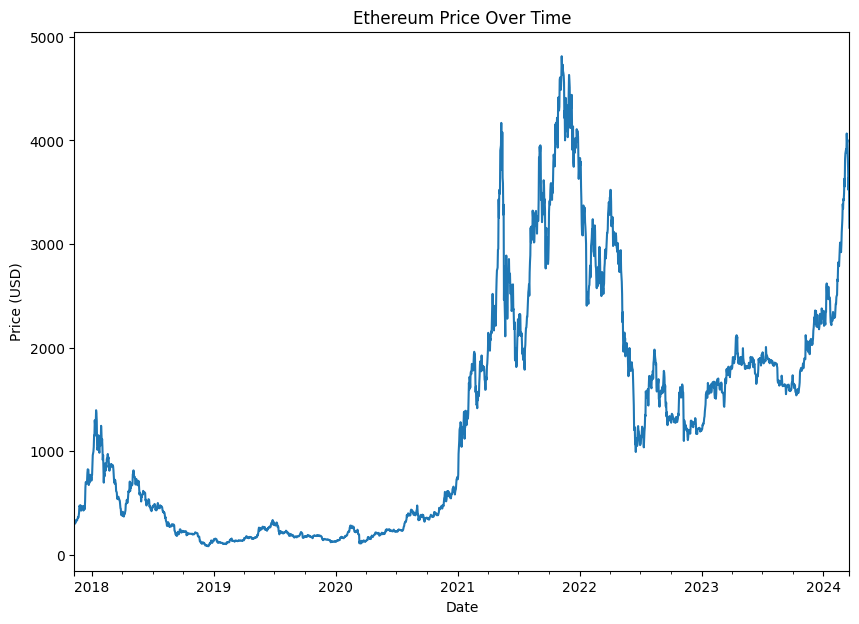

Epoch 1/30
29/29 [==============================] - 12s 187ms/step - loss: 0.0166 - val_loss: 0.0035
Epoch 2/30
29/29 [==============================] - 4s 129ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 3/30
29/29 [==============================] - 5s 167ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/30
29/29 [==============================] - 4s 131ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/30
29/29 [==============================] - 4s 128ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 6/30
29/29 [==============================] - 5s 168ms/step - loss: 0.0028 - val_loss: 8.6332e-04
Epoch 7/30
29/29 [==============================] - 4s 130ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/30
29/29 [==============================] - 4s 129ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 9/30
29/29 [==============================] - 5s 159ms/step - loss: 0.0025 - val_loss: 6.9016e-04
Epoch 10/30
29/29 [==============================] - 4s 139ms/step - loss: 0.0022 - val_los

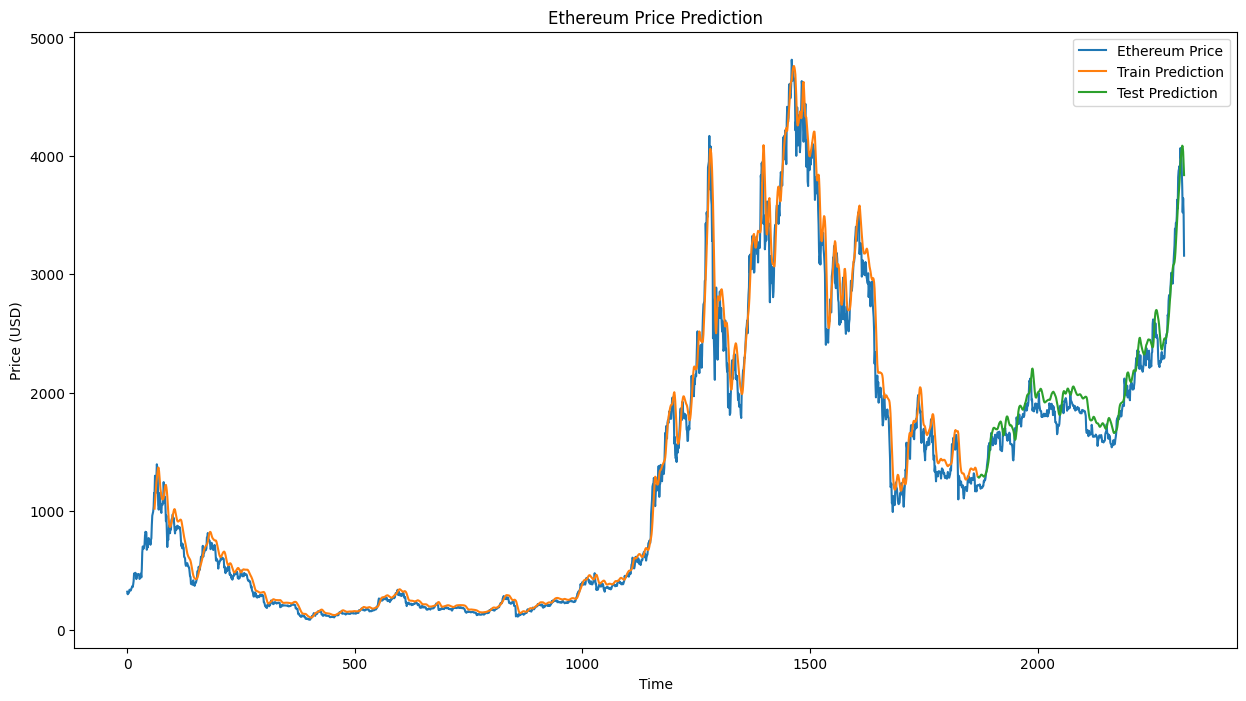

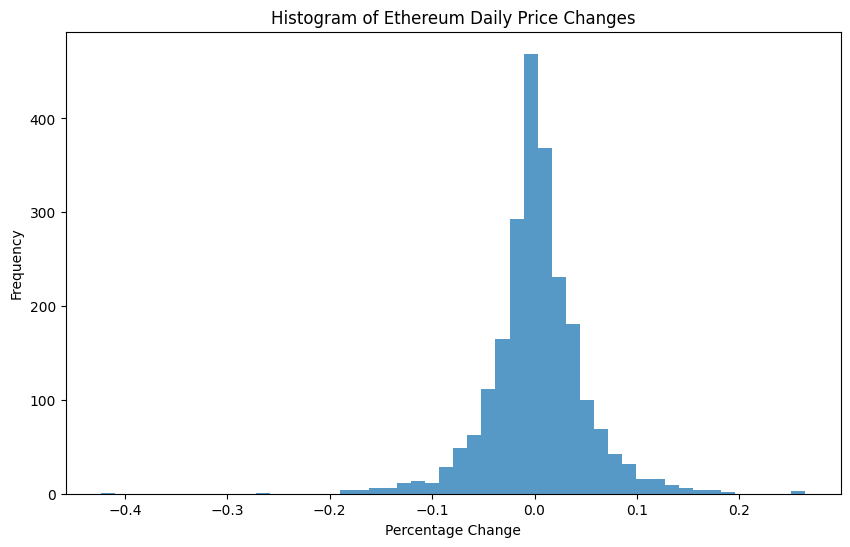

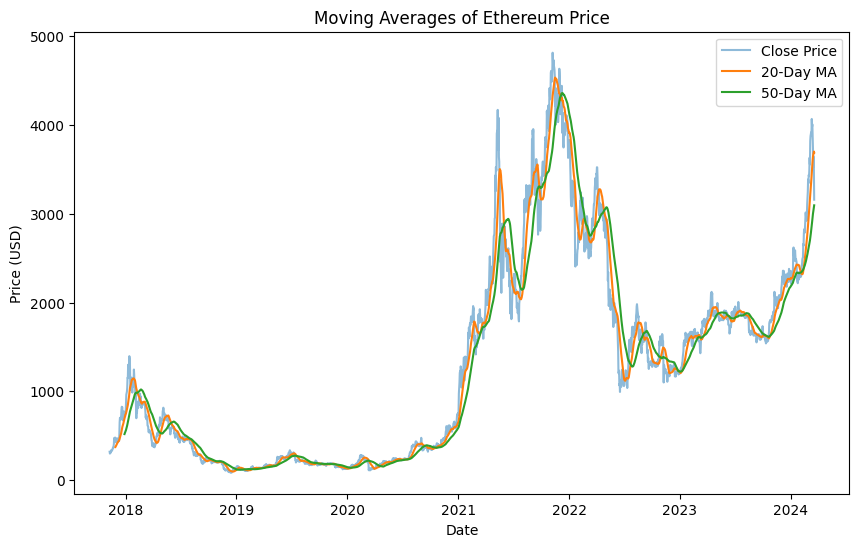

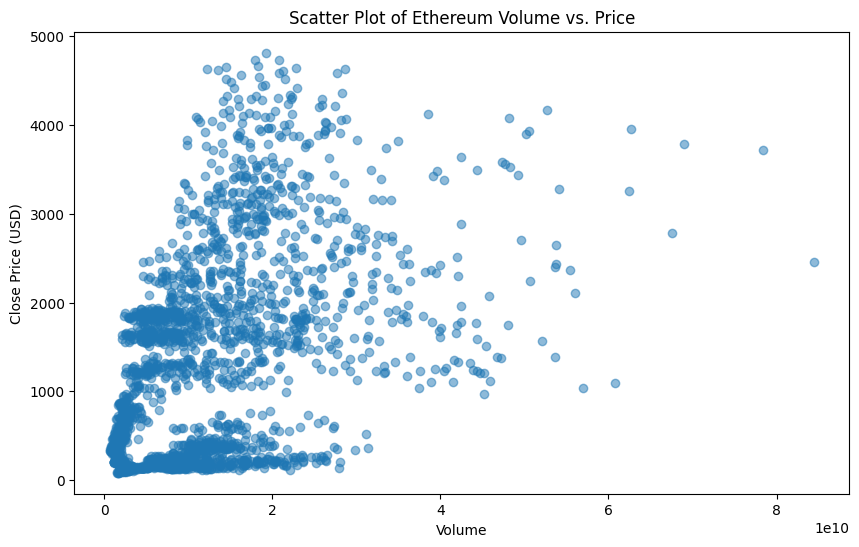

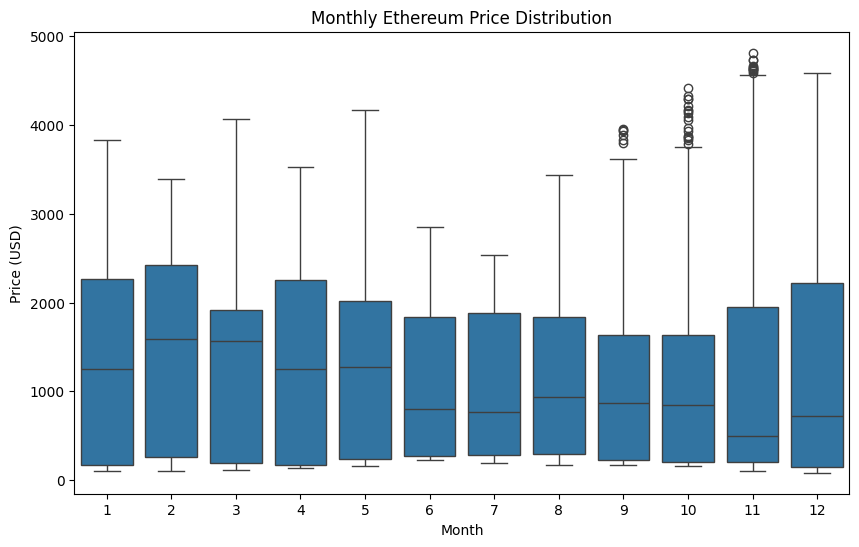

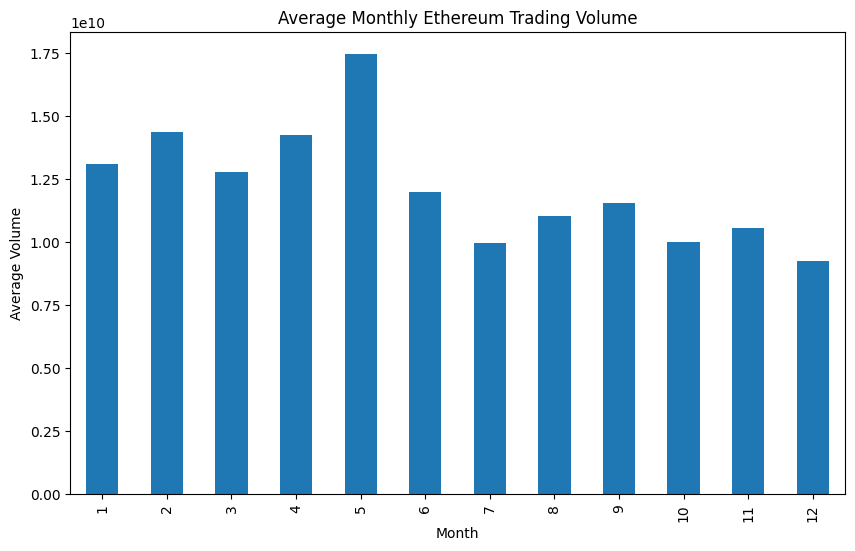

<ipython-input-1-38384f43117e>:152: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




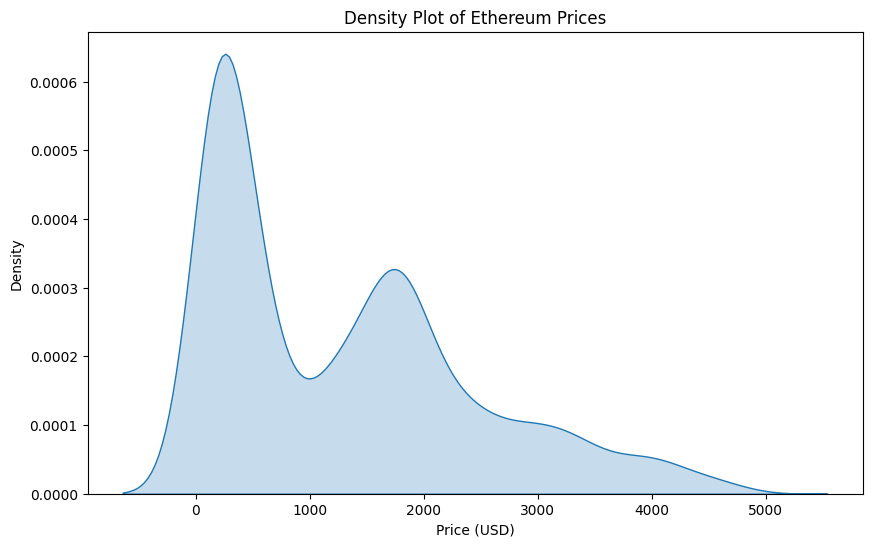

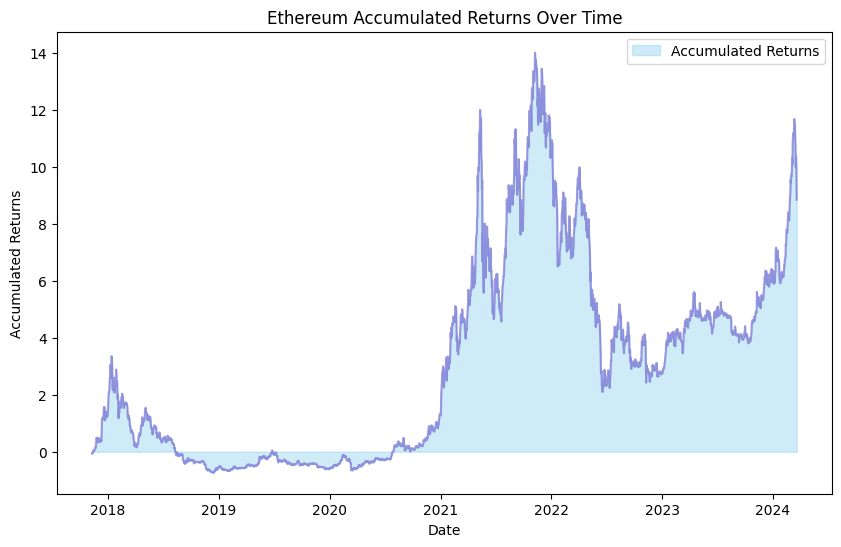

1/1 [==============================] - 0s 44ms/step


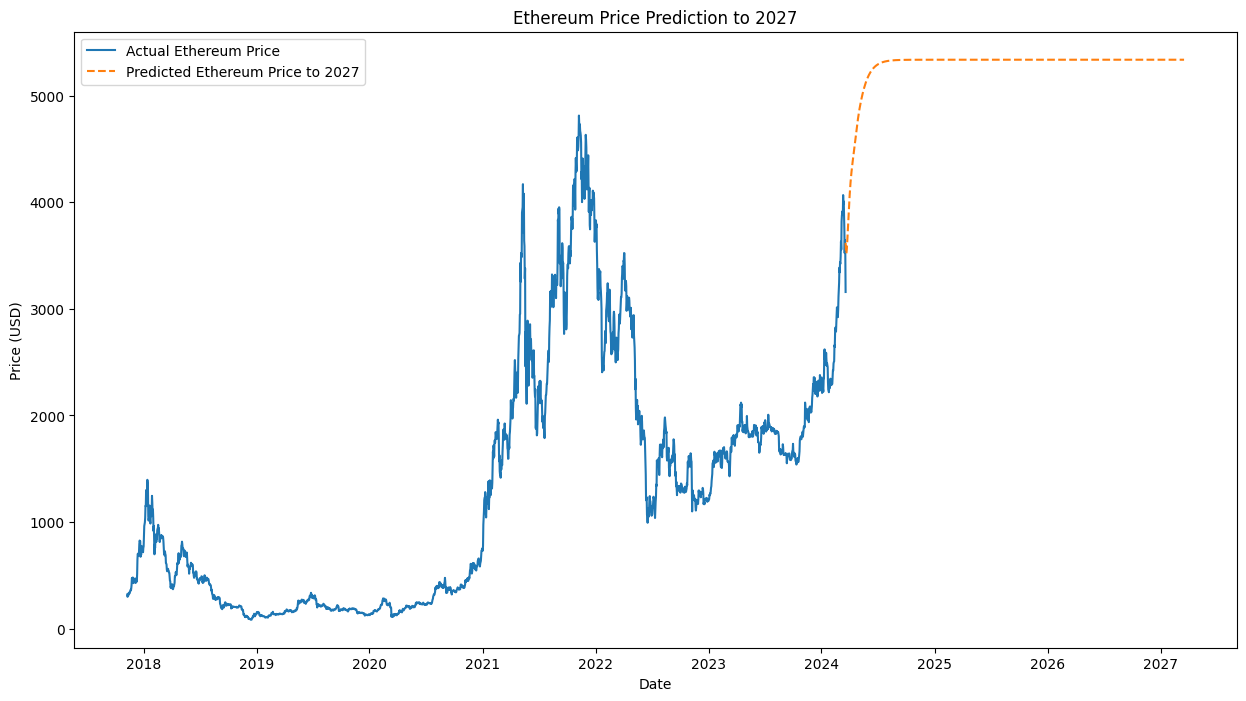

In [ ]:
# Install required libraries
!pip install yfinance

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go

# Download historical Ethereum price data from Yahoo Finance
eth_data = yf.download('ETH-USD', start='2016-01-01', end='2024-03-20')

# Plot Ethereum price over time
eth_data.Close.plot(figsize=(10, 7), title="Ethereum Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_data['Close'].values.reshape(-1, 1))

# Create a function to prepare the data for the LSTM model
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the data
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
training_size = int(len(X) * 0.8)
test_size = len(X) - training_size
X_train, X_test = X[0:training_size], X[training_size:len(X)]
y_train, y_test = y[0:training_size], y[training_size:len(y)]


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, verbose=1)

# Make predictions on the training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the scaled predictions back to the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plot the actual prices and predicted prices
look_back = 60
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(scaled_data)-len(test_predict):len(scaled_data), :] = test_predict

plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(scaled_data), label='Ethereum Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Ethereum Price Prediction')
plt.legend()
plt.show()

# Create a candlestick chart of Ethereum price
fig = go.Figure(data=[go.Candlestick(x=eth_data.index,
                open=eth_data['Open'],
                high=eth_data['High'],
                low=eth_data['Low'],
                close=eth_data['Close'])])
fig.update_layout(title='Ethereum Price Candlestick Chart', xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()

# Calculate daily price changes and plot a histogram
price_changes = eth_data['Close'].pct_change()
plt.figure(figsize=(10, 6))
plt.hist(price_changes, bins=50, alpha=0.75)
plt.title('Histogram of Ethereum Daily Price Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.show()

# Calculate moving averages and plot them with the price
eth_data['MA20'] = eth_data['Close'].rolling(window=20).mean()
eth_data['MA50'] = eth_data['Close'].rolling(window=50).mean()

plt.figure(figsize=(10, 6))
plt.plot(eth_data.index, eth_data['Close'], label='Close Price', alpha=0.5)
plt.plot(eth_data.index, eth_data['MA20'], label='20-Day MA')
plt.plot(eth_data.index, eth_data['MA50'], label='50-Day MA')
plt.title('Moving Averages of Ethereum Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Create a scatter plot of Ethereum volume vs. price
plt.figure(figsize=(10, 6))
plt.scatter(eth_data['Volume'], eth_data['Close'], alpha=0.5)
plt.title('Scatter Plot of Ethereum Volume vs. Price')
plt.xlabel('Volume')
plt.ylabel('Close Price (USD)')
plt.show()

# Create a new column for the month and plot a box plot of monthly price distribution
eth_data['Month'] = eth_data.index.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=eth_data)
plt.title('Monthly Ethereum Price Distribution')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.show()

# Calculate the average monthly trading volume and plot it
monthly_volume = eth_data.groupby('Month')['Volume'].mean()
plt.figure(figsize=(10, 6))
monthly_volume.plot(kind='bar')
plt.title('Average Monthly Ethereum Trading Volume')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.show()

# Create a density plot of Ethereum prices
plt.figure(figsize=(10, 6))
sns.kdeplot(eth_data['Close'], shade=True)
plt.title('Density Plot of Ethereum Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.show()

# Calculate accumulated returns and plot them
returns = eth_data['Close'].pct_change().dropna()
cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.fill_between(cumulative_returns.index, cumulative_returns, label='Accumulated Returns', color='skyblue', alpha=0.4)
plt.plot(cumulative_returns, color='Slateblue', alpha=0.6)
plt.title('Ethereum Accumulated Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Accumulated Returns')
plt.legend()
plt.show()

# Generate future predictions for the next 3 years (2024-2027)
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape((1, time_step, 1))

days_to_predict = 3 * 365

future_predictions = []

for _ in range(days_to_predict):
    next_day_prediction = model.predict(last_sequence)
    future_predictions.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction[0, 0]

future_predictions_array = np.array(future_predictions).reshape(-1, 1)
inverse_predictions = scaler.inverse_transform(future_predictions_array)

# Plot the future predictions
future_dates = pd.date_range(start=eth_data.index[-1], periods=len(future_predictions), freq='D')
plt.figure(figsize=(15, 8))
plt.plot(eth_data.index, eth_data['Close'], label='Actual Ethereum Price')
plt.plot(future_dates, inverse_predictions, label='Predicted Ethereum Price to 2027', linestyle='--')
plt.title('Ethereum Price Prediction to 2027')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Install required libraries
!pip install yfinance

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go

In [ ]:
eth_data = yf.download('ETH-USD', start='2016-01-01', end='2024-03-20')

[*********************100%%**********************]  1 of 1 completed


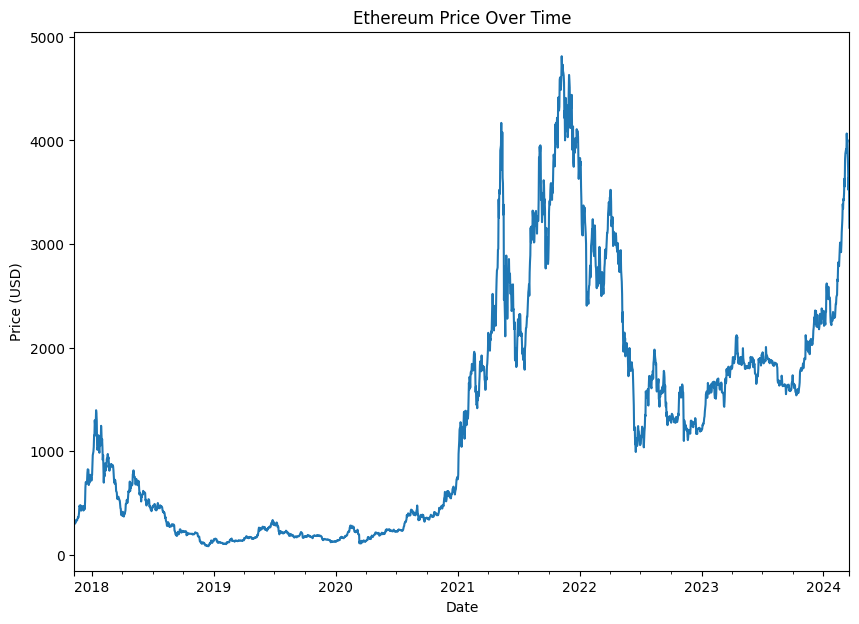

In [ ]:
eth_data.Close.plot(figsize=(10, 7), title="Ethereum Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(eth_data['Close'].values.reshape(-1, 1))

In [ ]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

training_size = int(len(X) * 0.8)
test_size = len(X) - training_size
X_train, X_test = X[0:training_size], X[training_size:len(X)]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

In [ ]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

training_size = int(len(X) * 0.8)
test_size = len(X) - training_size
X_train, X_test = X[0:training_size], X[training_size:len(X)]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
29/29 [==============================] - 23s 368ms/step - loss: 0.0017 - val_loss: 7.2808e-04
Epoch 2/30
29/29 [==============================] - 6s 201ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 3/30
29/29 [==============================] - 5s 182ms/step - loss: 0.0016 - val_loss: 4.1724e-04
Epoch 4/30
29/29 [==============================] - 6s 199ms/step - loss: 0.0014 - val_loss: 4.0262e-04
Epoch 5/30
29/29 [==============================] - 8s 262ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/30
29/29 [==============================] - 8s 267ms/step - loss: 0.0015 - val_loss: 4.5316e-04
Epoch 7/30
29/29 [==============================] - 5s 159ms/step - loss: 0.0013 - val_loss: 4.0150e-04
Epoch 8/30
29/29 [==============================] - 6s 212ms/step - loss: 0.0013 - val_loss: 3.0189e-04
Epoch 9/30
29/29 [==============================] - 8s 285ms/step - loss: 0.0015 - val_loss: 3.9914e-04
Epoch 10/30
29/29 [==============================] - 6s 218ms/step - lo

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

15/15 [==============================] - 0s 27ms/step


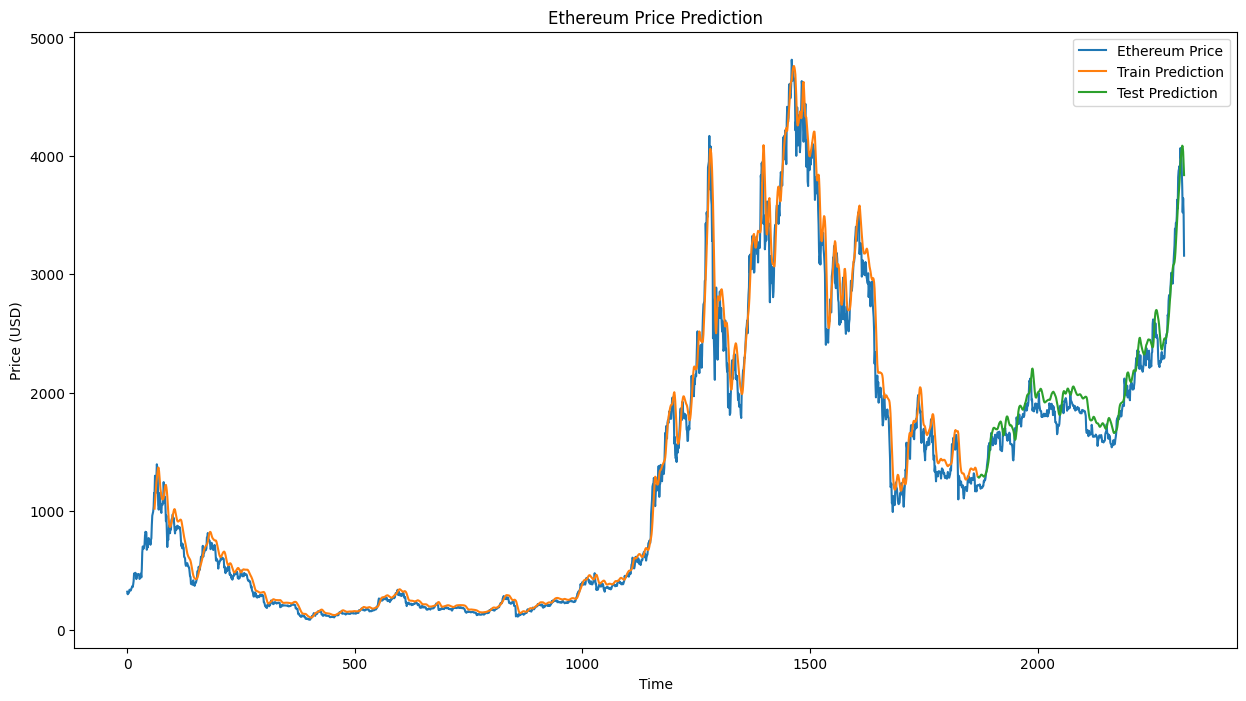

In [ ]:
look_back = 60
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(scaled_data)-len(test_predict):len(scaled_data), :] = test_predict

plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(scaled_data), label='Ethereum Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Ethereum Price Prediction')
plt.legend()
plt.show()

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=eth_data.index,
                open=eth_data['Open'],
                high=eth_data['High'],
                low=eth_data['Low'],
                close=eth_data['Close'])])
fig.update_layout(title='Ethereum Price Candlestick Chart', xaxis_title='Date', yaxis_title='Price (USD)')
fig.show()

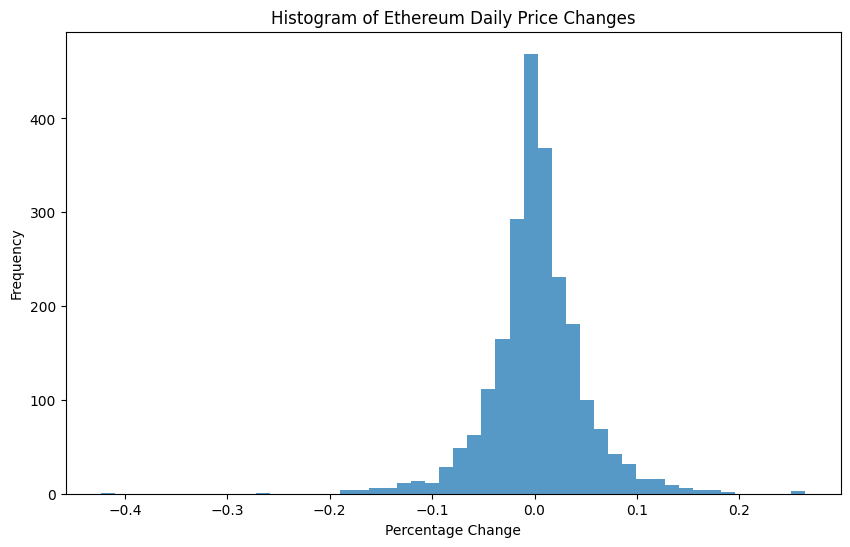

In [ ]:
price_changes = eth_data['Close'].pct_change()
plt.figure(figsize=(10, 6))
plt.hist(price_changes, bins=50, alpha=0.75)
plt.title('Histogram of Ethereum Daily Price Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.show()

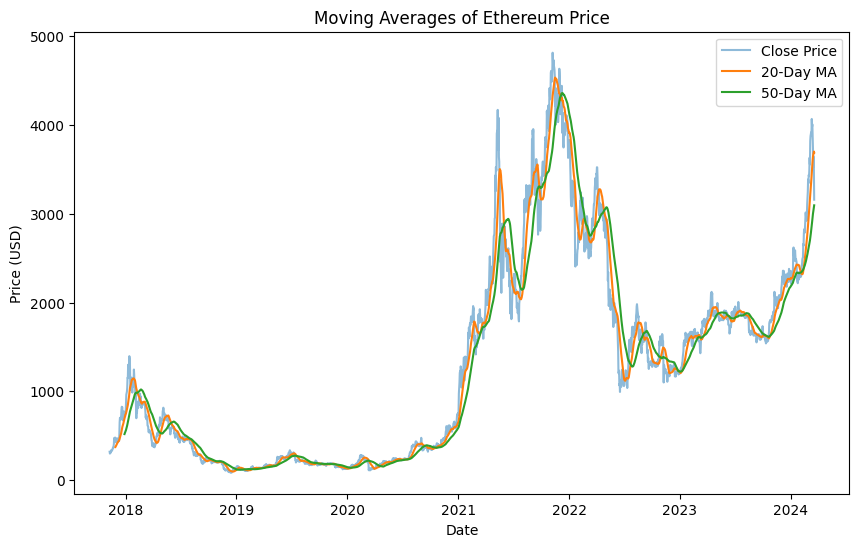

In [ ]:
eth_data['MA20'] = eth_data['Close'].rolling(window=20).mean()
eth_data['MA50'] = eth_data['Close'].rolling(window=50).mean()

plt.figure(figsize=(10, 6))
plt.plot(eth_data.index, eth_data['Close'], label='Close Price', alpha=0.5)
plt.plot(eth_data.index, eth_data['MA20'], label='20-Day MA')
plt.plot(eth_data.index, eth_data['MA50'], label='50-Day MA')
plt.title('Moving Averages of Ethereum Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

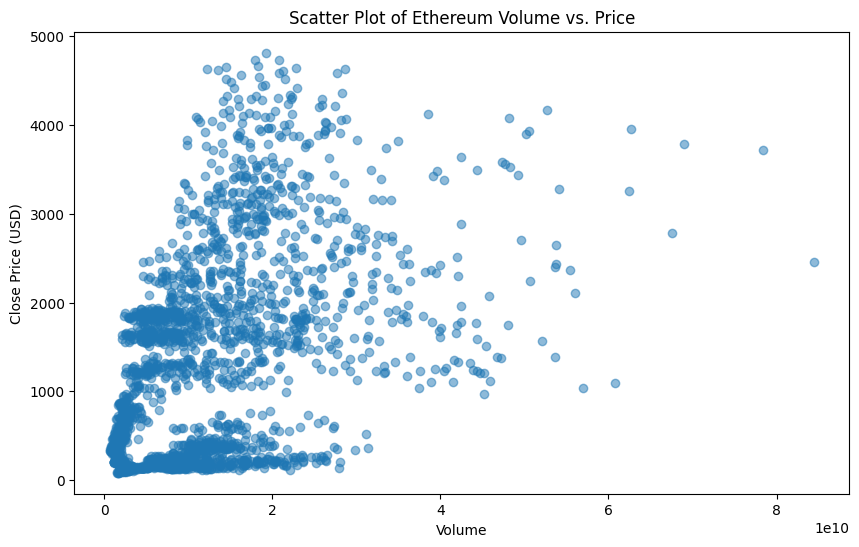

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(eth_data['Volume'], eth_data['Close'], alpha=0.5)
plt.title('Scatter Plot of Ethereum Volume vs. Price')
plt.xlabel('Volume')
plt.ylabel('Close Price (USD)')
plt.show()

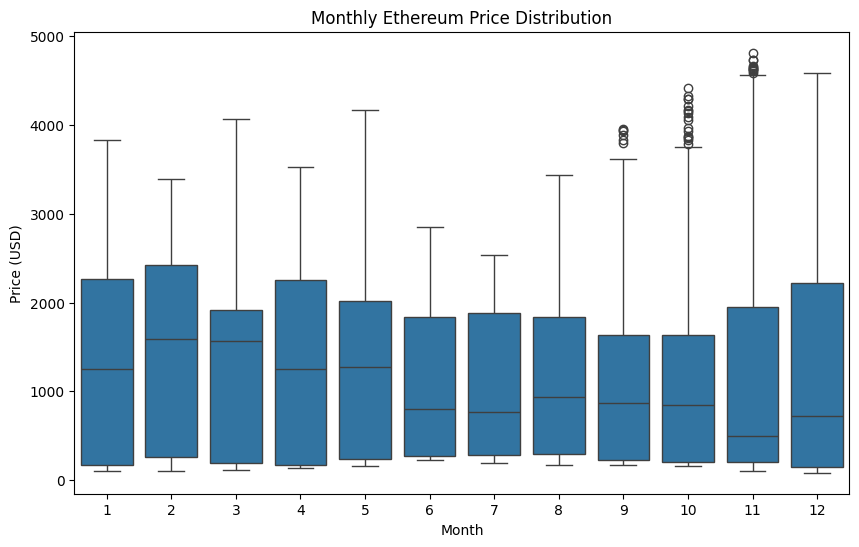

In [ ]:
eth_data['Month'] = eth_data.index.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Close', data=eth_data)
plt.title('Monthly Ethereum Price Distribution')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.show()

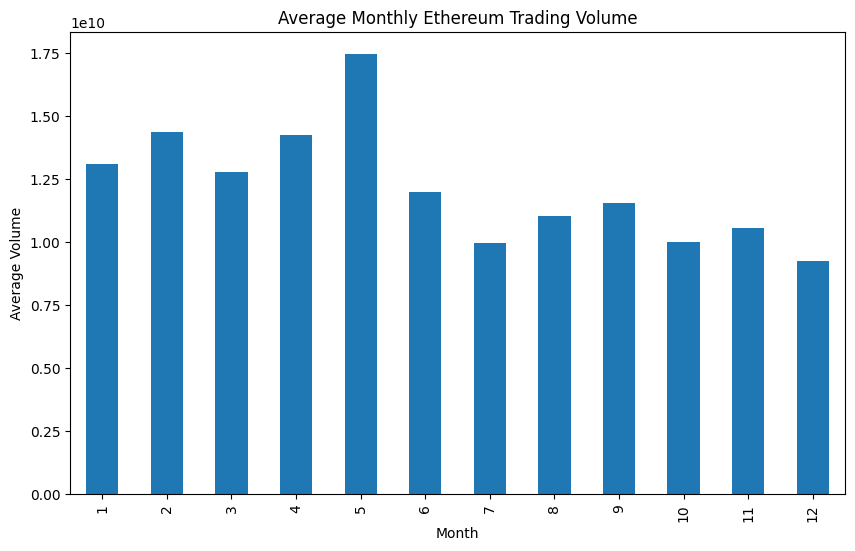

In [ ]:
monthly_volume = eth_data.groupby('Month')['Volume'].mean()
plt.figure(figsize=(10, 6))
monthly_volume.plot(kind='bar')
plt.title('Average Monthly Ethereum Trading Volume')
plt.xlabel('Month')
plt.ylabel('Average Volume')
plt.show()

<ipython-input-18-7cf834f3ffc0>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




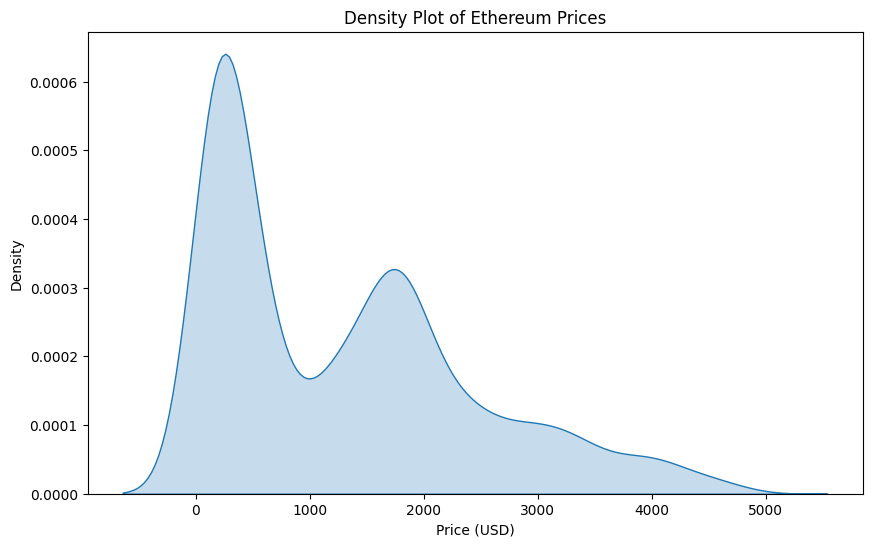

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(eth_data['Close'], shade=True)
plt.title('Density Plot of Ethereum Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.show()

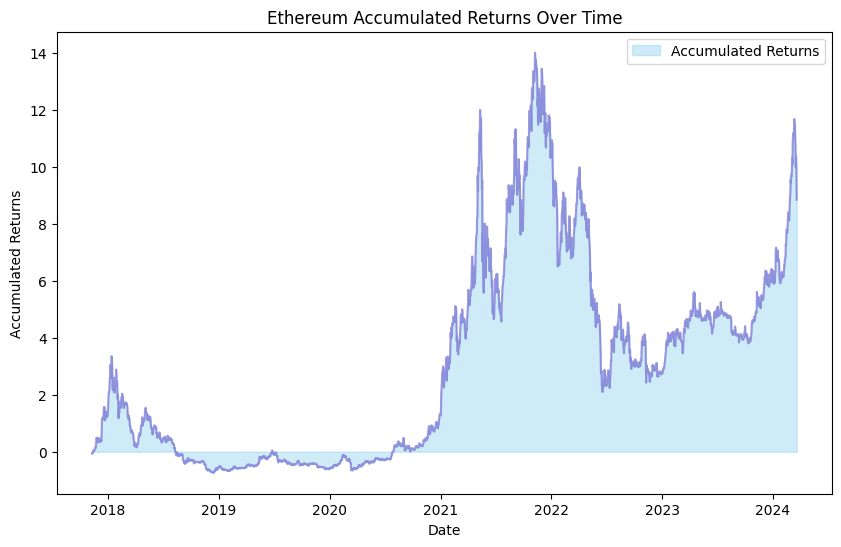

In [ ]:
returns = eth_data['Close'].pct_change().dropna()
cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.fill_between(cumulative_returns.index, cumulative_returns, label='Accumulated Returns', color='skyblue', alpha=0.4)
plt.plot(cumulative_returns, color='Slateblue', alpha=0.6)
plt.title('Ethereum Accumulated Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Accumulated Returns')
plt.legend()
plt.show()

In [ ]:
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape((1, time_step, 1))

days_to_predict = 3 * 365

future_predictions = []

for _ in range(days_to_predict):
    next_day_prediction = model.predict(last_sequence)
    future_predictions.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction[0, 0]

future_predictions_array = np.array(future_predictions).reshape(-1, 1)
inverse_predictions = scaler.inverse_transform(future_predictions_array)

1/1 [==============================] - 0s 32ms/step


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
29/29 [==============================] - 14s 286ms/step - loss: 0.0012 - mae: 0.0214 - val_loss: 3.1262e-04 - val_mae: 0.0128
Epoch 2/30
29/29 [==============================] - 4s 131ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 2.0747e-04 - val_mae: 0.0104
Epoch 3/30
29/29 [==============================] - 4s 133ms/step - loss: 9.1319e-04 - mae: 0.0193 - val_loss: 2.1896e-04 - val_mae: 0.0113
Epoch 4/30
29/29 [==============================] - 5s 171ms/step - loss: 9.2436e-04 - mae: 0.0192 - val_loss: 3.0640e-04 - val_mae: 0.0142
Epoch 5/30
29/29 [==============================] - 4s 143ms/step - loss: 9.0755e-04 - mae: 0.0189 - val_loss: 2.3124e-04 - val_mae: 0.0117
Epoch 6/30
29/29 [==============================] - 4s 133ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 1.8524e-04 - val_mae: 0.0097
Epoch 7/30
29/29 [==============================] - 5s 170ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 6.0408e-04 - val_mae: 0.0201
Epoch 8/30
29/29 [=================

In [ ]:
# Evaluate the model on the test data
mse, mae = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)

print('Test MSE: %.4f' % mse)
print('Test RMSE: %.4f' % rmse)
print('Test MAE: %.4f' % mae)

15/15 [==============================] - 0s 27ms/step - loss: 2.1040e-04 - mae: 0.0097
Test MSE: 0.0002
Test RMSE: 0.0145
Test MAE: 0.0097


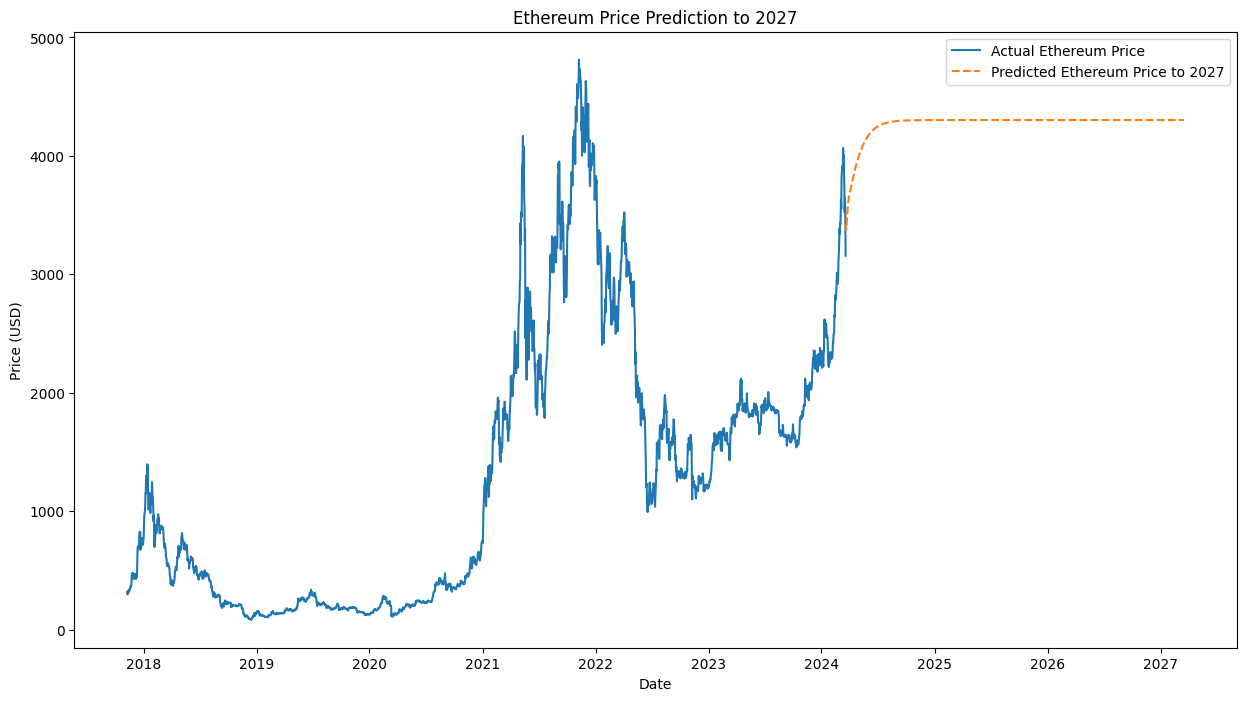

In [ ]:
future_dates = pd.date_range(start=eth_data.index[-1], periods=len(future_predictions), freq='D')
plt.figure(figsize=(15, 8))
plt.plot(eth_data.index, eth_data['Close'], label='Actual Ethereum Price')
plt.plot(future_dates, inverse_predictions, label='Predicted Ethereum Price to 2027', linestyle='--')
plt.title('Ethereum Price Prediction to 2027')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
print(eth_data.isnull().sum())

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA20         19
MA50         49
Month         0
dtype: int64


In [ ]:
eth_data = eth_data[~eth_data.index.duplicated(keep='first')]

In [ ]:
Q1 = np.percentile(eth_data['Close'], 25)
Q3 = np.percentile(eth_data['Close'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = eth_data[(eth_data['Close'] < lower_bound) | (eth_data['Close'] > upper_bound)]

price_changes = eth_data['Close'].pct_change()

In [ ]:
price_changes = eth_data['Close'].pct_change()

In [ ]:
eth_data['Returns'] = eth_data['Close'].pct_change()

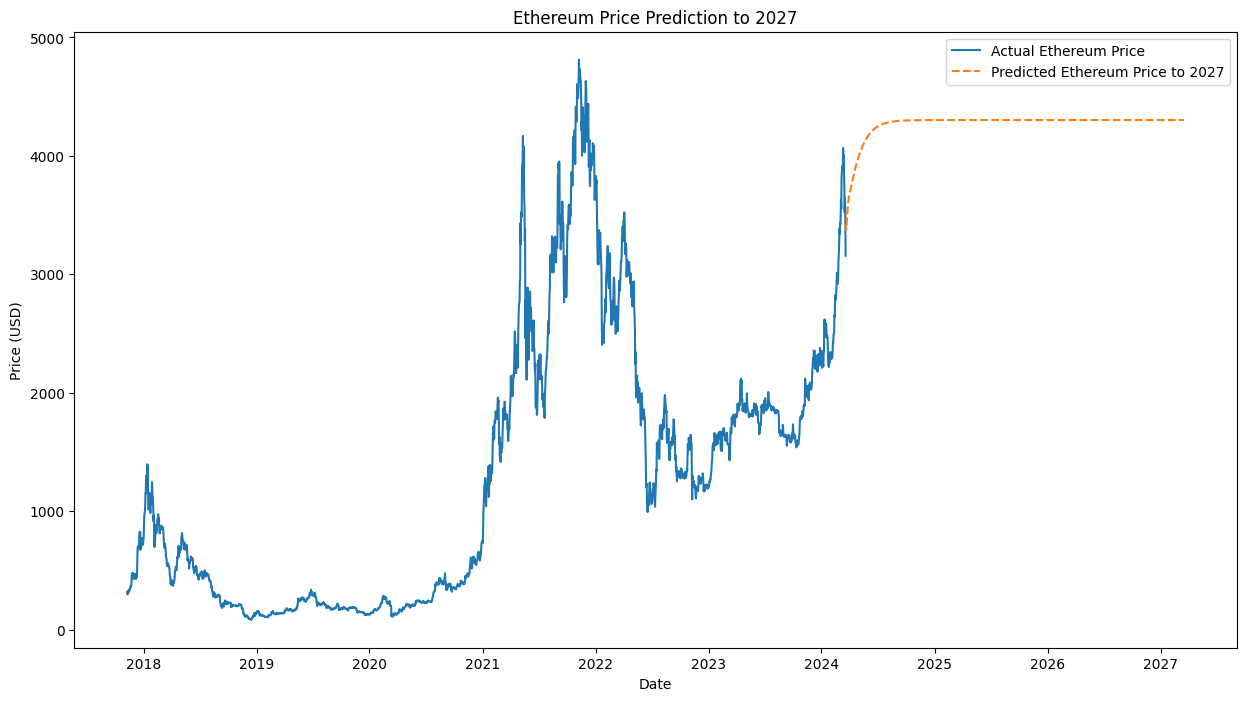

In [ ]:
future_dates = pd.date_range(start=eth_data.index[-1], periods=len(future_predictions), freq='D')
plt.figure(figsize=(15, 8))
plt.plot(eth_data.index, eth_data['Close'], label='Actual Ethereum Price')
plt.plot(future_dates, inverse_predictions, label='Predicted Ethereum Price to 2027', linestyle='--')
plt.title('Ethereum Price Prediction to 2027')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()